# Домашнее задание № 7 

In [28]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import os
import cv2
import skimage
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

# Поиск объектов в видеопотоке 

Задача - придумать и реализовать алгоритм поиска (обнаружения без классификации) движущихся объектов.

В качестве исходных данных приведена выборка с видеофайлами и аннотацией для каждого кадра файла. Аннотация задана в виде ограничивающих прямоугольников в формате ```(y1,x1,y2,x2)```, где
- ```(x1,y1)``` - верхний левый угол прямоугольника;
- ```(x2,y2)``` - нижний правый угол прямоугольника.

Ссылка на данные – https://disk.yandex.ru/d/RdjMDoQQO8Ngcw

В качестве обучающей можно брать любые видеофайлы. При этом должны быть отдельно выбраны тестовые данные, которые не будут использованы в создании решения. 

Видеофайл с результатами работы алгоритма должен быть прикреплен вместе с решением. Пример фрагмента видеофайла с результатом поиска объектов приведен ниже.

Исходный код может быть в формате ```.py``` или ```.ipynb```.

![annotation](annot_example.gif "annotation")

## Требования к результату
- поиск должен находить геометрические место объекта на видеоизображении. Геометрическое место задано ограничивающим прямоугольником (bounding box);
- продолжительность решения для любого одного видеофайла не должна превышать 10 минут;
- должна быть приведена оценка точности решения;
- привести демонстрацию результатов требется на одном из тестовых видеофайлов.

In [29]:
def create_video(save_dir, size, img_format='jpg', vido_format='avi'):
    out_name = Path(save_dir).parts[-1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(Path(save_dir) / Path(f'{out_name}.{vido_format}')),
                          fourcc, 20, tuple(size.astype(int)))

    for fname in tqdm(sorted(map(str, Path(save_dir).glob(f'*.{img_format}')))):
        imag = skimage.io.imread(fname)
        out.write(imag)
    out.release()

In [30]:
def show_video(num=-1,path='./tmp/', sleep=0):
    cap = get_video(num if num >=0 else 0, path=path)
    get_video_details(cap)
    cv2.startWindowThread()
    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
            
        if sleep > 0:
            time.sleep(sleep)

        cv2.imshow("sparse optical flow", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [31]:
def spec_points(image):
    """
    Функция для поиска особых точек и получения их дескрипторов 
    """
    
    hyp_params = dict(
        nfeatures = 50,
        nOctaveLayers = 10,
        contrastThreshold = 0.01,
        edgeThreshold = 6,
        sigma = 2.0)  # hyp params
    detector = cv2.SIFT_create(**hyp_params)

    keypoints, desc = detector.detectAndCompute(image.copy(), None)
    return keypoints, desc

In [32]:
def get_keyp_and_d(first, second):
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    ratio_thresh = 0.7
    keypoints1, desc1 = spec_points(first)
    keypoints2, desc2 = spec_points(second)
    
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    dx = np.zeros(len(good_matches))
    dy = np.zeros(len(good_matches))
    for k, good_matche in enumerate(good_matches):
        x1, y1 = keypoints1[good_matche.queryIdx].pt
        x2, y2 = keypoints2[good_matche.trainIdx].pt
                
        dx[k] = x1 - x2
        dy[k] = y1 - y2
    return keypoints1, keypoints2, dx, dy, good_matches

In [33]:
def get_M(first, second):
    h, w = first.shape
    
    keypoints1 = [0]*4
    keypoints2 = [0]*4
    dx = [0]*4
    dy = [0]*4
    l_good_matches = [0]*4
    
    i = 0
    for hmin in [0, h//2]:
        for wmin in [0, h//2]:
            temp_l = get_keyp_and_d(first[hmin:hmin+h//2, wmin:wmin+w//2], second[hmin:hmin+h//2, wmin:wmin+w//2])
            keypoints1[i], keypoints2[i], dx[i], dy[i], l_good_matches[i] = temp_l
            i += 1
            
    av_dx = (dx[0].mean() + dx[1].mean() + dx[2].mean() + dx[3].mean())/4
    av_dy = (dy[0].mean() + dy[1].mean() + dy[2].mean() + dy[3].mean())/4
    
    pts1 = []
    pts2 = []   
    
    for i in range(4):
        ind = np.argmin((dx[i]-av_dx)**2 + (dy[i]-av_dx)**2)
        good_matche = l_good_matches[i][ind]
        pts1.append(keypoints1[i][good_matche.queryIdx].pt)
        pts2.append(keypoints2[i][good_matche.trainIdx].pt)
    
    pts1 = np.array(pts1).astype(np.float32)
    pts2 = np.array(pts2).astype(np.float32)
    
    
    print('pts1', pts1)
    print('pts2', pts2)
    
#     plt.imshow(first, cmap='gray')
#     plt.show()
#     plt.imshow(second, cmap='gray')
#     plt.show()
    M = cv2.getPerspectiveTransform(pts1, pts2)
#     if np.sum(np.abs(M - np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]))) < 0.1:
#         M = cv2.getAffineTransform(pts1[:3], pts2[:3])
#     else:
#         return M
#     if np.sum(np.abs(M - np.array([[0, 0, 0], [0, 0, 0]]))) < 0.1:
#         M = cv2.getAffineTransform(pts1[1:], pts2[1:])
    return M
    

In [39]:
def get_trajectory(cap, max_im=-1):
    get_video_details(cap)
    
    color = (0, 255, 0)
    feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    is_ok, first_frame = cap.read()
    if not is_ok:
        print("ERR: Can't read")
        return
#     plt.imshow(first_frame)
#     plt.show()
    
    prev_gray = cv2.cvtColor(first_frame.copy(), cv2.COLOR_BGR2GRAY)
#     prev = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    mask = np.zeros_like(first_frame)
    idx = 0
    while (cap.isOpened()):
        print("idx", idx)
        if max_im >=0 and idx > max_im:
            break
        is_ok, frame = cap.read()
#         if not is_ok or idx == 10:
#             break
        if not is_ok:
            break
        gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(frame)
        
#         print('prob:', np.sum((prev_gray - gray)**2))
        M = get_M(prev_gray.copy(), gray.copy())
#         if np.sum(np.abs(M - np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]))) < 0.1:
#             print('bad M')
#             break
        print('M',M)
        if M.shape[0] == 3:
            trans_prev_gray = cv2.warpPerspective(prev_gray.copy(), M, (prev_gray.shape[1], prev_gray.shape[0]))
        else:
            trans_prev_gray = cv2.warpAffine(prev_gray.copy(), M, (prev_gray.shape[1], prev_gray.shape[0]))
        
        prev = cv2.goodFeaturesToTrack(trans_prev_gray, mask=None, **feature_params)
    
        trans_gray = gray*(trans_prev_gray!=0).astype(np.uint8)
        plt.imshow(trans_prev_gray, cmap='gray')
        plt.show()

        
        nextp, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, trans_gray, prev, None, **lk_params)

        good_old = prev[status == 1].astype(int)
        good_new = nextp[status == 1].astype(int)

        # Draws the optical flow tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color, 2)
            frame = cv2.circle(frame, (a, b), 3, color, -1)

        output = cv2.add(frame, mask)
        prev_gray = gray.copy()
        # Updates previous good feature points
        prev = good_new.reshape(-1, 1, 2)

        cv2.imwrite(f'tmp/frame_{str(idx).zfill(4)}.jpg', output)
        idx += 1
        
        # Opens a new window and displays the output frame
#         cv2.imshow("sparse optical flow", output)
        
#         idx += 1
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

    # The following frees up resources and closes all windows
    cap.release()

['Clip_1.mov', 'Clip_10.mov', 'Clip_11.mov', 'Clip_2.mov', 'Clip_3.mov', 'Clip_37.mov', 'Clip_4.mov', 'Clip_5.mov', 'Clip_6.mov', 'Clip_7.mov', 'Clip_8.mov', 'Clip_9.mov']
./Videos/Videos/Clip_1.mov
309.0 1920.0 1080.0 29.97
idx 0
pts1 [[109.51596  165.36475 ]
 [ 12.194358  99.32567 ]
 [443.6265   355.5312  ]
 [ 29.002554 329.6863  ]]
pts2 [[105.41231  163.69409 ]
 [ 10.421646 101.43337 ]
 [431.25323  359.00684 ]
 [ 18.363214 333.78247 ]]
M [[ 8.23485611e-01 -6.62814833e-02  5.07993556e+00]
 [ 3.73839876e-01  1.73067176e-01  6.13547020e+01]
 [ 1.12778175e-03 -1.95781763e-03  1.00000000e+00]]


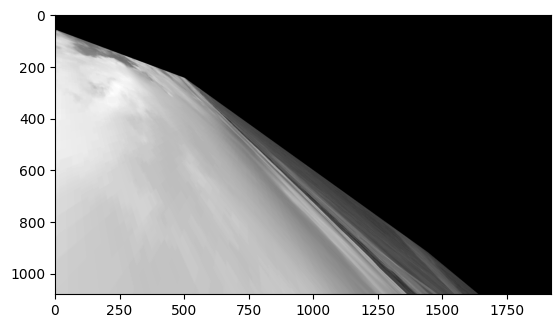

idx 1
pts1 [[468.2219   127.28503 ]
 [247.29115   32.815063]
 [756.95245  131.90005 ]
 [406.53528  108.3242  ]]
pts2 [[470.6745   129.60188 ]
 [246.22191   37.126396]
 [750.141    135.99603 ]
 [400.4218   114.14975 ]]
M [[ 2.04320409e+01 -2.70201156e+01 -2.98545451e+03]
 [ 2.58260948e+00  1.23405150e+00 -5.01144820e+02]
 [ 1.84185609e-02 -2.31638287e-02  1.00000000e+00]]


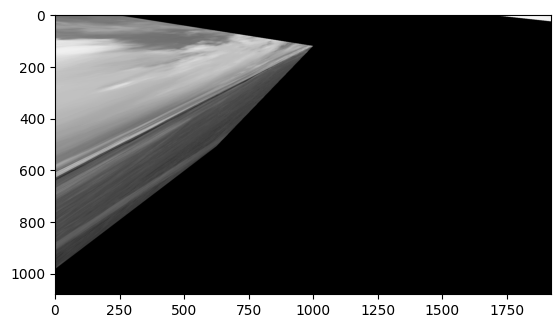

idx 2
pts1 [[ 83.35224   80.52535 ]
 [273.96738   67.481445]
 [859.9842   225.93546 ]
 [307.34396  234.09973 ]]
pts2 [[ 80.81262   78.389114]
 [272.10458   71.67478 ]
 [852.883    230.95824 ]
 [300.2889   238.97043 ]]
M [[ 9.87596187e-01 -2.62027558e-01  1.53772077e+01]
 [ 3.56014329e-02  7.98963045e-01  6.99441652e+00]
 [ 1.45091992e-04 -7.98198242e-04  1.00000000e+00]]


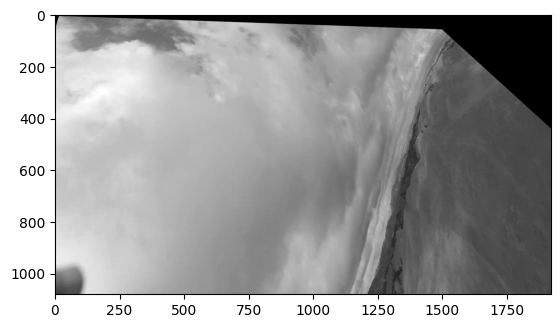

idx 3
pts1 [[ 96.71238  160.38112 ]
 [ 59.197628 307.3156  ]
 [567.5153   260.15198 ]
 [129.93105  272.4394  ]]
pts2 [[ 92.823685 158.18425 ]
 [ 54.443012 310.0894  ]
 [558.63336  262.8011  ]
 [121.69584  276.5603  ]]
M [[ 1.13554721e+00  4.20655063e-02 -1.30044752e+01]
 [-2.84711505e-02  1.39435628e+00 -4.43885249e+01]
 [-9.19668824e-05  7.76872574e-04  1.00000000e+00]]


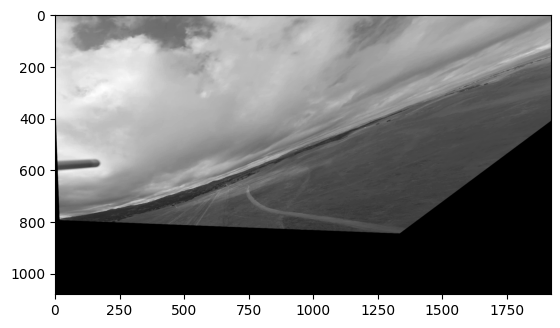

idx 4
pts1 [[ 95.96627  295.49707 ]
 [ 60.541584  24.18318 ]
 [526.8514   345.6382  ]
 [101.42786  246.45393 ]]
pts2 [[ 89.34432  293.77612 ]
 [ 60.530632  25.693384]
 [517.35535  348.48187 ]
 [ 93.28554  249.8845  ]]
M [[ 7.06430158e-01  5.58505912e-02  1.43329601e+01]
 [-2.50518999e-01  1.13658956e+00  1.24915389e+01]
 [-8.13201733e-04  6.15818531e-04  1.00000000e+00]]


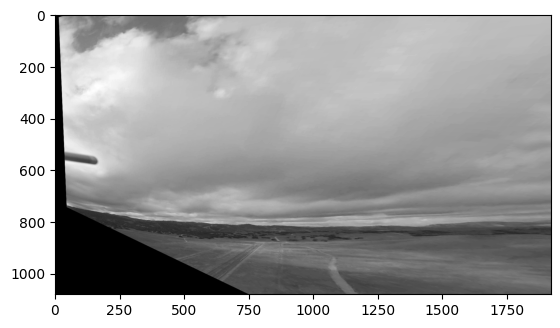

idx 5
pts1 [[132.47903  149.28076 ]
 [ 60.530632  25.693384]
 [607.82794  306.63586 ]
 [ 67.82795  306.63586 ]]
pts2 [[128.90468  143.96353 ]
 [ 60.412094  27.288836]
 [599.2529   308.82913 ]
 [ 59.252956 308.82913 ]]
M [[ 9.66791292e-01 -5.50824037e-02  3.18148848e+00]
 [ 4.71280097e-02  8.64075853e-01  2.17848294e+00]
 [ 1.52602221e-04 -4.40283484e-04  1.00000000e+00]]


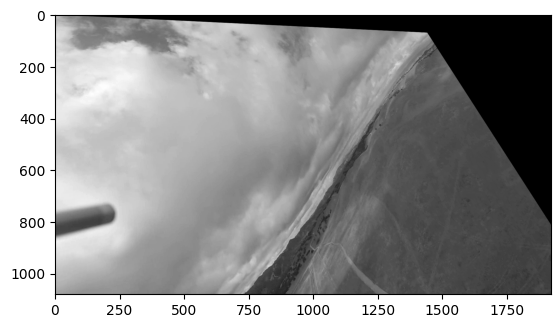

idx 6
pts1 [[ 85.467896 154.30621 ]
 [ 60.412094  27.288836]
 [472.02374  368.01862 ]
 [ 59.252956 308.82913 ]]
pts2 [[ 80.49215  151.36311 ]
 [ 59.607723  27.562847]
 [462.93658  369.02402 ]
 [ 50.893345 310.129   ]]
M [[ 9.41025808e-01 -3.56124212e-02  3.46354512e+00]
 [-8.43204457e-03  9.46270217e-01  2.12632765e+00]
 [ 2.91938502e-06 -1.70397415e-04  1.00000000e+00]]


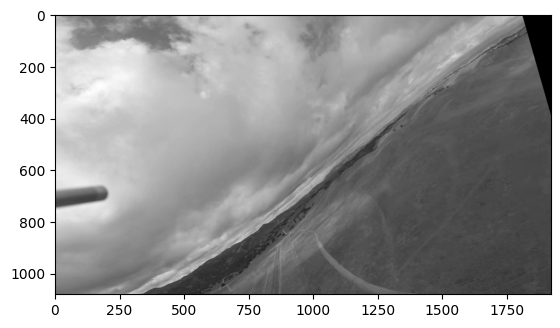

idx 7
pts1 [[ 74.97893  288.3584  ]
 [ 59.607723  27.562847]
 [443.79816  378.0437  ]
 [ 23.949736 320.64478 ]]
pts2 [[ 67.510086  285.6729   ]
 [ 57.39516    27.309195 ]
 [433.7021    378.35223  ]
 [ 15.8900385 321.33685  ]]
M [[ 9.12441348e-01 -3.45896138e-02  3.66820188e+00]
 [ 3.31343773e-03  9.03358317e-01  2.07372156e+00]
 [ 4.89093820e-05 -2.90222339e-04  1.00000000e+00]]


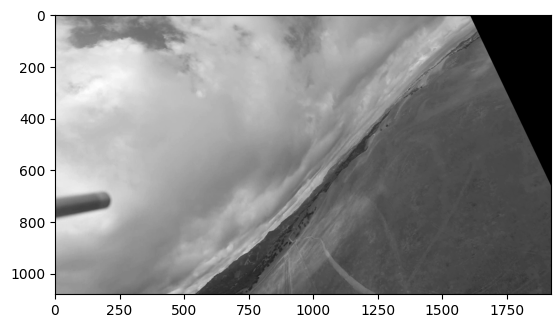

idx 8
pts1 [[139.82758   38.612274]
 [ 36.376217 314.59366 ]
 [608.7562   255.32498 ]
 [ 68.75621  255.32498 ]]
pts2 [[134.62558   35.096634]
 [ 30.802925 313.79556 ]
 [602.0151   255.70805 ]
 [ 62.01505  255.70805 ]]
M [[ 9.52968081e-01 -1.04767879e-02  2.65616438e-01]
 [-2.74977885e-02  1.03168505e+00 -1.28863208e+00]
 [-1.07535869e-04  9.83062274e-05  1.00000000e+00]]


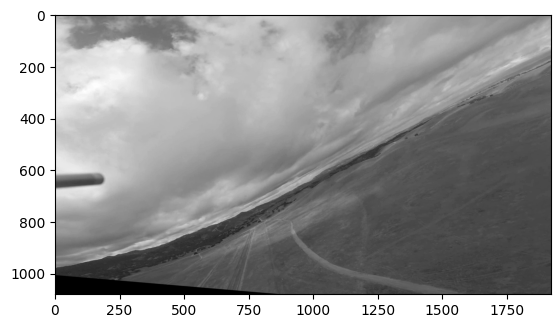

idx 9
pts1 [[306.92023 136.60315]
 [260.9806   85.75898]
 [939.1298  162.47818]
 [399.12982 162.47818]]
pts2 [[303.07693  134.3331  ]
 [257.82385   85.320244]
 [933.9246   163.26735 ]
 [393.92465  163.26735 ]]
M [[ 6.52908894e-01 -2.95449505e-01  7.49411813e+01]
 [-1.34625234e-02  6.28630598e-01  2.24062344e+01]
 [-8.24569250e-05 -1.45971288e-03  1.00000000e+00]]


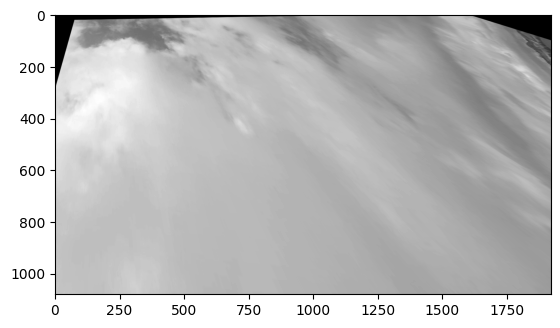

idx 10
pts1 [[ 49.476276 280.31165 ]
 [233.0357    55.09768 ]
 [372.96234  396.36496 ]
 [ 42.101944 390.56506 ]]
pts2 [[ 41.68567  277.18024 ]
 [230.41405   54.38189 ]
 [364.1094   396.4014  ]
 [ 34.578743 390.62772 ]]
M [[ 1.09547257e+00  8.44455794e-03 -1.39399616e+01]
 [ 7.93755605e-02  1.06982022e+00 -2.03705198e+01]
 [ 2.01592297e-04  4.49813760e-05  1.00000000e+00]]


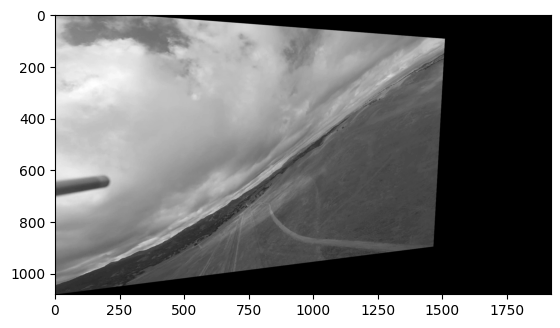

idx 11
pts1 [[192.49681  115.757996]
 [255.02205   85.32284 ]
 [181.89763  449.4037  ]
 [ 48.14804  256.18286 ]]
pts2 [[185.54893  108.92945 ]
 [251.99748   84.657455]
 [170.64905  449.1947  ]
 [ 41.45245  256.4773  ]]
M [[ 1.67771388e+00  3.07708216e-01 -9.60177278e+01]
 [ 5.77116669e-01  2.29745101e+00 -2.22903459e+02]
 [ 1.01737735e-03  1.89346663e-03  1.00000000e+00]]


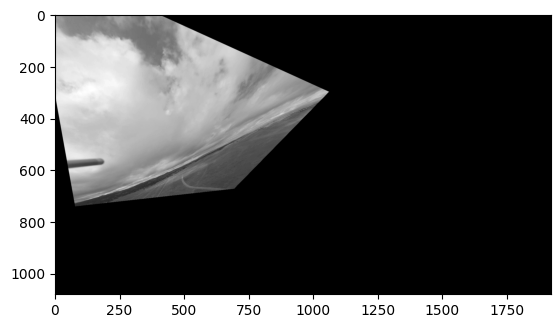

idx 12
pts1 [[123.6075  117.34681]
 [228.40518  53.96982]
 [680.5116  157.00426]
 [ 41.45245 256.4773 ]]
pts2 [[118.30427  114.22194 ]
 [226.24406   54.304794]
 [674.0907   158.40282 ]
 [ 34.097298 257.8923  ]]
M [[ 1.14048854e+00  5.33782359e-02 -2.78765632e+01]
 [ 4.14699029e-02  9.95020289e-01 -6.64707323e+00]
 [ 2.14487053e-04 -1.49873473e-04  1.00000000e+00]]


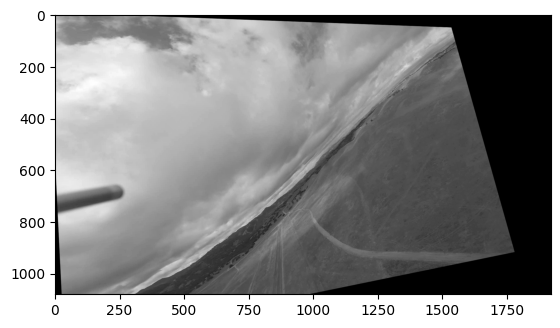

idx 13
pts1 [[ 41.58036  132.71158 ]
 [249.5877    85.369446]
 [483.79333  273.4325  ]
 [190.6247   228.48781 ]]
pts2 [[ 37.819725 130.0217  ]
 [247.67554   87.278755]
 [475.59427  274.7529  ]
 [184.32109  230.7628  ]]
M [[ 9.92782119e-01 -1.49013587e-01  1.39800084e+01]
 [ 3.60826271e-02  8.81607370e-01  3.49323474e+00]
 [ 2.03061271e-04 -5.28904414e-04  1.00000000e+00]]


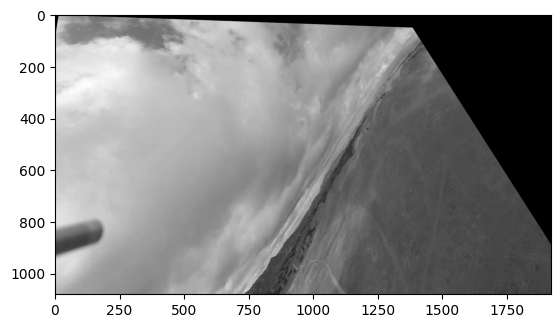

KeyboardInterrupt: 

In [40]:
cap = get_video(0)
get_trajectory(cap, 100)
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')


In [24]:
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')

  0%|          | 0/308 [00:00<?, ?it/s]

In [25]:
show_video(sleep=0)

['tmp.mp4']
./tmp/tmp.mp4
308.0 1920.0 1080.0 20.0


In [35]:
def get_video_details(cap):
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(cnt, w, h, fps)

In [36]:
def get_video(num, path='./Videos/Videos/'):
    """
    Функция достающая видео
    num - номер видео (если num == -1, то достаются все видео)
    
    """
    all_names = os.listdir(path)
    names = []
    for name in all_names:
        if name.endswith(".mov") or name.endswith(".mp4"):
            names.append(name)
    print(names)
    if num >= 0:
        name_vid = names[num]
        print(path+name_vid)
        return cv2.VideoCapture(path+name_vid)
    
    videos = []
    for name_vid in names:
        videos.append(cv2.VideoCapture(path+name_vid))
    return videos
    

In [170]:
show_video(0, './Videos/Videos/', 1)

['Clip_1.mov', 'Clip_10.mov', 'Clip_11.mov', 'Clip_2.mov', 'Clip_3.mov', 'Clip_37.mov', 'Clip_4.mov', 'Clip_5.mov', 'Clip_6.mov', 'Clip_7.mov', 'Clip_8.mov', 'Clip_9.mov']
./Videos/Videos/Clip_1.mov
309.0 1920.0 1080.0 29.97


In [171]:
show_video(sleep=1)

['tmp.mov']
./tmptmp.mov
0.0 0.0 0.0 0.0


In [ ]:
create_video('tmp', size=np.array((1920.0 , 1080.0)), vido_format='mp4')
show_video(sleep=1)